# Plotting and Visualizing Dynamics and Relationships of Trust Behavior

## Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from scipy import stats

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import constants

In [2]:
pd.set_option("display.max_columns",
              None)

## Read Evaluation Results

In [3]:
# NOTE: first, run the jupyter notebook : "evaluate_trust_behavior.ipynb"
# OR: directly use already evaluated results (.xlsx) in the directory : ("./results/experiments/")

In [4]:
learning_results_df = pd.read_excel("learning_stage_experiment_results.xlsx")

In [5]:
inference_results_df = pd.read_excel("inference_stage_experiment_results.xlsx")

## Optimization Process Plots from Learning Trust Behavior

In [6]:
last_step_learning_results_df = learning_results_df[learning_results_df["Experiment"] != learning_results_df["Experiment"].shift(-1)]

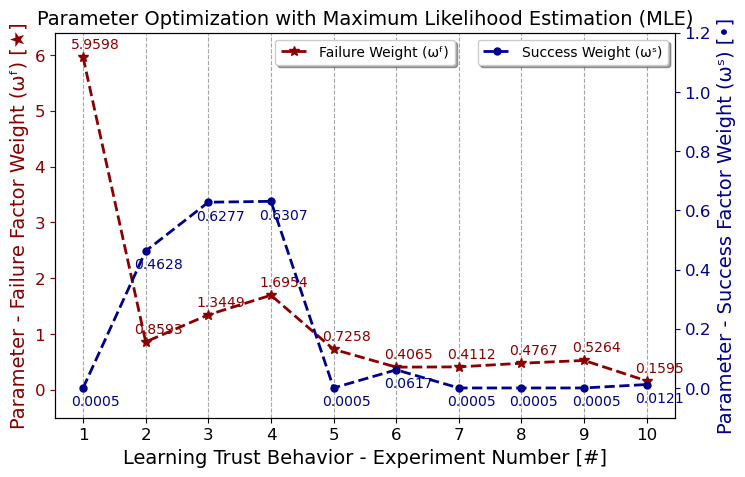

In [7]:
experiment_column = "Experiment"
success_weight_column = "SuccessWeight"
failure_weight_column = "FailureWeight"

fig, ax1 = plt.subplots(1, 1,
                        figsize=(8, 5))

failure_scatter = ax1.plot(last_step_learning_results_df[experiment_column],
                           last_step_learning_results_df[failure_weight_column],
                           color="darkred",
                           marker="*",
                           markersize=7,
                           linestyle="--",
                           linewidth=2,
                           label="Failure Weight (\u03C9\u1da0)")

ax1.set_title("Parameter Optimization with Maximum Likelihood Estimation (MLE)", fontsize=14)
ax1.set_xlabel("Learning Trust Behavior - Experiment Number [#]",
               fontsize=14)
ax1.set_ylabel(f"Parameter - Failure Factor Weight (\u03C9\u1da0) [★]",
               color="darkred",
               fontsize=14)
ax1.tick_params("y",
                colors="darkred")

success_scatter = ax1.twinx()

success_scatter.plot(last_step_learning_results_df[experiment_column],
                     last_step_learning_results_df[success_weight_column],
                     color="darkblue",
                     marker="o",
                     markersize=5,
                     linestyle="--",
                     linewidth=2,
                     label="Success Weight (\u03C9\u02E2)")

success_scatter.set_ylabel(f"Parameter - Success Factor Weight (\u03C9\u02E2) [•]",
                           color="darkblue",
                           fontsize=14)
success_scatter.tick_params("y",
                            colors="darkblue")

success_scatter.set_ylim(success_scatter.get_ylim()[0],
                         success_scatter.get_ylim()[1] * 2)

ax1.set_xticks(np.arange(1,
                         len(last_step_learning_results_df) + 1))

ax1.tick_params(axis="x",
                labelsize=12)
ax1.tick_params(axis="y",
                labelsize=12)
success_scatter.tick_params(axis="y",
                            labelsize=12)

ax1.set_ylim(-0.5, 6.4)
success_scatter.set_ylim(-0.1, 1.2)

ax1.grid(True,
         which="both",
         axis="x",
         linestyle="--",
         color="grey",
         alpha=0.7)

for x, y_failure, y_success in zip(last_step_learning_results_df[experiment_column],
                                   last_step_learning_results_df[failure_weight_column],
                                   last_step_learning_results_df[success_weight_column]):
    ax1.text(x + 0.2,
             y_failure + 0.1,
             f"{y_failure:.4f}",
             color="darkred",
             ha="center",
             va="bottom")
    
    success_scatter.text(x + 0.2,
                         y_success - 0.07,
                         f"{y_success:.4f}",
                         color="darkblue",
                         ha="center",
                         va="bottom")

ax1.legend(loc="upper center",
           shadow=True,
           labels=["Failure Weight (\u03C9\u1da0)"],
           fontsize=10)
success_scatter.legend(loc="upper right",
           shadow=True,
           labels=["Success Weight (\u03C9\u02E2)"],
           fontsize=10)

plt.savefig("learning_stage_success_failure_weights.png", dpi=600, bbox_inches="tight")

plt.show()

In [8]:
experiment_column = "Experiment"
time_step_column = "TimeStep"
alpha_column = "Alpha"
beta_column = "Beta"
label_column = "TrustLabel"
reward_column = "Reward"

exp_numbers_ = []
avg_rewards_ = []
trust_labels_ = []
trust_estims_ = []
percentile_5s_ = []
percentile_95s_ = []

# calculate average reward of each scenario trajectory
avg_reward_per_learning_experiment = learning_results_df[
    reward_column].groupby(learning_results_df.index // constants.TRAJECTORY_SIZE).agg("mean").values

for exp_number in range(1, learning_results_df[experiment_column].max() + 1):
    exp_numbers_.append(exp_number)
    
    # calculate average reward of particular scenario trajectory
    avg_reward_value = learning_results_df[learning_results_df[experiment_column] == exp_number][reward_column].mean()
    avg_rewards_.append(avg_reward_value)
    
    trust_label_value = last_step_learning_results_df[last_step_learning_results_df[experiment_column] == exp_number][label_column].item()
    trust_labels_.append(trust_label_value)
    
    # create a beta distribution at the last step of each experiment in learning trust behavior experiments
    beta_dist = stats.beta(last_step_learning_results_df[last_step_learning_results_df[experiment_column] == exp_number][alpha_column].item(),
                           last_step_learning_results_df[last_step_learning_results_df[experiment_column] == exp_number][beta_column].item())

    # get 5th and 95th percentiles of each scenario trajectory last step prediction
    percentile_5 = beta_dist.ppf(0.05)
    percentile_95 = beta_dist.ppf(0.95)
    
    percentile_5s_.append(percentile_5)
    percentile_95s_.append(percentile_95)
    
    trust_estim = beta_dist.mean()
    trust_estims_.append(trust_estim)

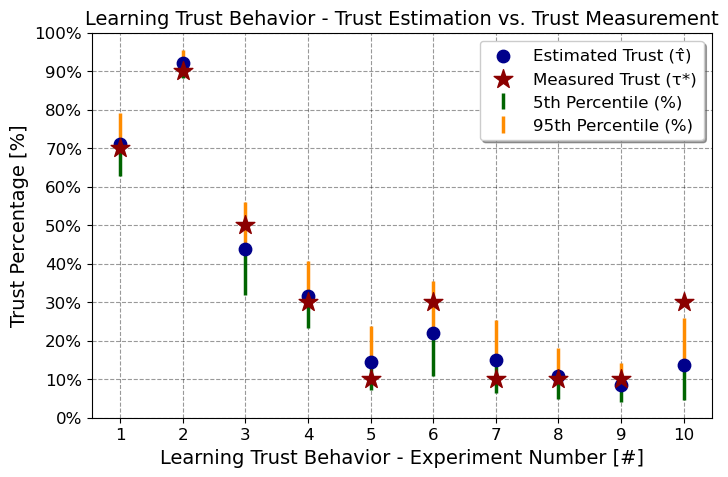

In [9]:
fig, ax1 = plt.subplots(1, 1,
                        figsize=(8, 5))

errorbar_min = ax1.errorbar(exp_numbers_,
                            trust_estims_,
                            yerr=[np.array(trust_estims_) - np.array(percentile_5s_),
                                  np.zeros_like(percentile_95s_)],
                            linestyle="None",
                            color="darkgreen",
                            alpha=1.0,
                            elinewidth=2.5,
                            zorder=2)
errorbar_max = ax1.errorbar(exp_numbers_,
                            trust_estims_,
                            yerr=[np.zeros_like(percentile_5s_),
                                  np.array(percentile_95s_) - np.array(trust_estims_)],
                            linestyle="None",
                            color="darkorange",
                            alpha=1.0,
                            elinewidth=2.5,
                            zorder=2)

for bar_min in errorbar_min[1]:
    bar_min.set_marker("_")
    bar_min.set_markersize(10)
    bar_min.set_markerfacecolor("darkgreen")

for bar_max in errorbar_max[1]:
    bar_max.set_marker("_")
    bar_max.set_markersize(10)
    bar_max.set_markerfacecolor("darkorange")

ax1.scatter(exp_numbers_,
            trust_estims_,
            color="darkblue",
            marker="o",
            s=80,
            zorder=3)

ax1.scatter(exp_numbers_,
            trust_labels_,
            color="darkred",
            marker="*",
            s=200,
            zorder=4)

ax1.set_ylim(0.0, 1.0)
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0,
                                                          decimals=0))
ax1.set_xticks(np.arange(1,
                         len(last_step_learning_results_df) + 1))
plt.yticks(np.arange(0, 1.1, 0.1),
           fontsize=12)

ax1.tick_params(axis="x",
                labelsize=12)
ax1.tick_params(axis="y",
                labelsize=12)

ax1.legend(loc="upper right",
           shadow=True,
           labels=["Estimated Trust (τ̂)",
                   "Measured Trust (τ*)",
                   "5th Percentile (%)",
                   "95th Percentile (%)"],
           fontsize=12)

ax1.set_xlabel("Learning Trust Behavior - Experiment Number [#]",
               fontsize=14)
ax1.set_ylabel("Trust Percentage [%]",
               fontsize=14)
ax1.set_title("Learning Trust Behavior - Trust Estimation vs. Trust Measurement",
              fontsize=14)

ax1.grid(True,
         which="both",
         axis="both",
         linestyle="--",
         color="black",
         alpha=0.4,
         zorder=1)

plt.savefig(f"learning_experiments_self_estimated_vs_measured_trust.png", dpi=600, bbox_inches="tight")

plt.show()

## Testing Process Plots from Inference Experiments

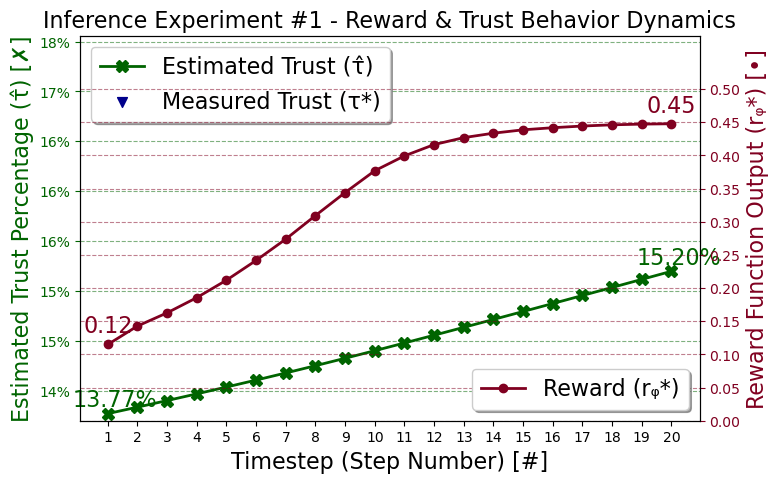

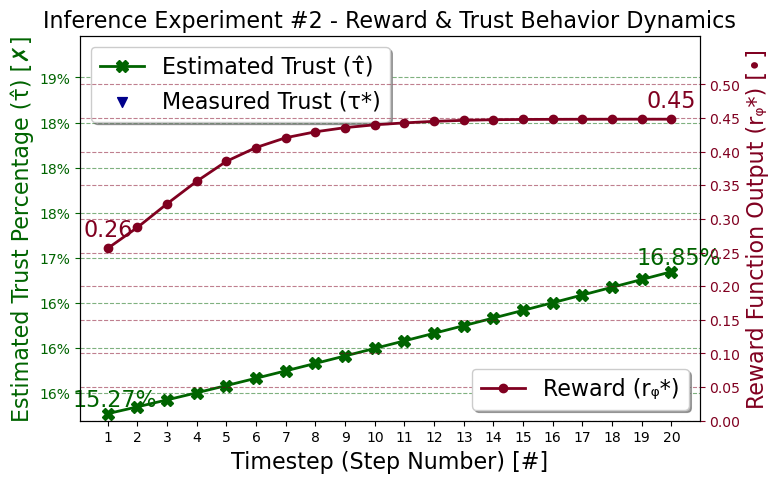

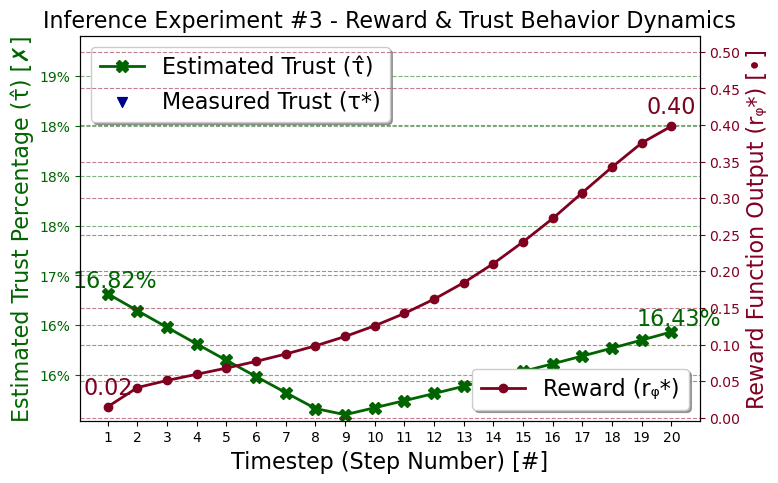

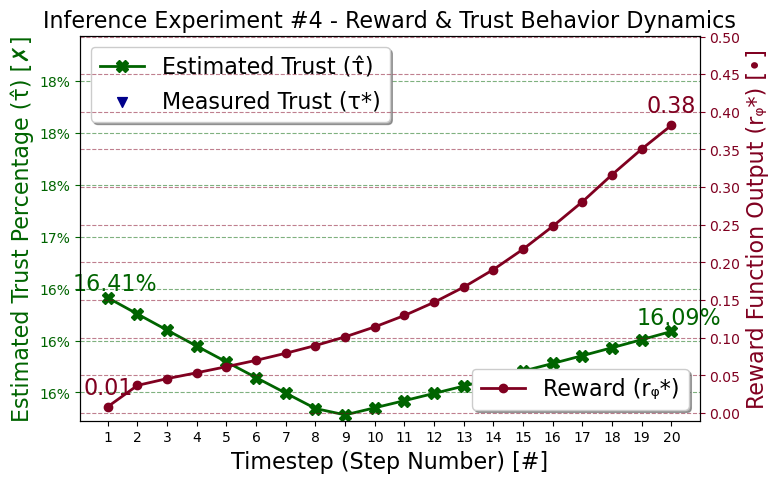

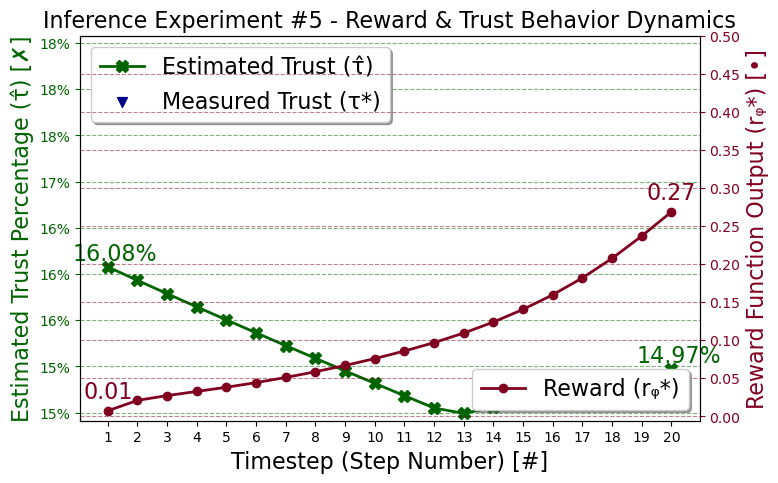

In [10]:
experiment_column = "Experiment"
timestep_column = "TimeStep"
reward_column = "Reward"
estimation_column = "TrustEstimation"
label_column = "TrustLabel"

for exp_number in range(1, inference_results_df[experiment_column].max() + 1):

    experiment_df = inference_results_df[inference_results_df[experiment_column] == exp_number]

    fig, ax1 = plt.subplots(1, 1,
                            figsize=(8, 5))

    trust_scatter = ax1.plot(experiment_df[timestep_column],
                             experiment_df[estimation_column],
                             color="#006400",
                             marker="X",
                             markersize=8,
                             linestyle="-",
                             linewidth=2,
                             label="Estimated Trust (τ̂)")

    ax1.set_title(f"Inference Experiment #{exp_number} - Reward & Trust Behavior Dynamics",
                  fontsize=16)
    ax1.set_xlabel("Timestep (Step Number) [#]",
                   fontsize=16)
    ax1.set_ylabel(f"Estimated Trust Percentage (τ̂) [\u2717]",
                   color="#006400",
                   fontsize=16)
    ax1.tick_params("y",
                    colors="#006400")

    reward_scatter = ax1.twinx()

    reward_scatter.plot(experiment_df[timestep_column],
                        experiment_df[reward_column],
                        color="#800020",
                        marker="o",
                        markersize=6,
                        linestyle="-",
                        linewidth=2,
                        label="Reward (rᵩ*)")

    reward_scatter.set_ylabel(f"Reward Function Output (rᵩ*) [•]",
                              color="#800020",
                              fontsize=16)
    reward_scatter.tick_params("y",
                               colors="#800020")

    ax1.set_ylim(ax1.get_ylim()[0],
                 ax1.get_ylim()[1] * 1.15)
    reward_scatter.set_ylim(reward_scatter.get_ylim()[0],
                 reward_scatter.get_ylim()[1] * 1.25)

    ax1.scatter(experiment_df[timestep_column].iloc[-1],
                experiment_df[label_column].iloc[-1],
                color="darkblue",
                marker="v",
                s=50,
                label="Measured Trust (τ*)")

    min_y = 0.0
    max_y = 0.5
    increment = 0.05
    reward_scatter.set_yticks(np.arange(min_y,
                                        max_y + increment,
                                        increment))
    def percent_formatter(x, pos):
        return f"{x*100:.0f}%"

    ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    ax1.set_xticks(np.arange(1,
                             len(experiment_df) + 1))
    ax1.grid(True,
             which="both",
             axis="y",
             linestyle="--",
             color="#006400",
             alpha=0.5)
    reward_scatter.grid(True,
                        which="both",
                        axis="y",
                        linestyle="--",
                        color="#800020",
                        alpha=0.5)

    first_trust = (experiment_df[timestep_column].iloc[0],
                   experiment_df[estimation_column].iloc[0])
    last_trust = (experiment_df[timestep_column].iloc[-1],
                  experiment_df[estimation_column].iloc[-1])
    ax1.annotate(f"{first_trust[1]*100:.2f}%",
                 first_trust,
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center",
                 color="#006400",
                 fontsize=16)
    ax1.annotate(f"{last_trust[1]*100:.2f}%",
                 last_trust,
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center",
                 color="#006400",
                 fontsize=16)
    ax1.annotate(f"{experiment_df[label_column].iloc[-1]*100:.0f}%",
                 (experiment_df[timestep_column].iloc[-1], experiment_df[label_column].iloc[-1]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center",
                 color="darkblue",
                 fontsize=16)

    reward_scatter.text(experiment_df[timestep_column].iloc[0],
                        experiment_df[reward_column].iloc[0] + 0.01,
                        f"{experiment_df[reward_column].iloc[0]:.2f}",
                        color="#800020",
                        fontsize=16,
                        ha="center",
                        va="bottom")
    reward_scatter.text(experiment_df[timestep_column].iloc[-1],
                        experiment_df[reward_column].iloc[-1] + 0.01,
                        f"{experiment_df[reward_column].iloc[-1]:.2f}",
                        color="#800020",
                        fontsize=16,
                        ha="center",
                        va="bottom")
    
    ax1.legend(loc="upper left", shadow=True, labels=["Estimated Trust (τ̂)", "Measured Trust (τ*)"], fontsize=16)
    reward_scatter.legend(loc="lower right", shadow=True, labels=["Reward (rᵩ*)"], fontsize=16)
    
#     ax1.annotate("Trust Measurement",
#                  xy=(experiment_df[timestep_column].iloc[-1] - 0.008,
#                      experiment_df[label_column].iloc[-1] - 0.006),  # position of the star marker
#                  xytext=(12, 0.26),  # position of the text
#                  arrowprops=dict(facecolor="black", shrink=0.02),  # optional arrow for reference
#                  fontsize=16)

#     check visibility of the specific point in ax1
#     ax1.set_ylim(0.10, 0.4)

#     plt.savefig(f"inference_experiment_{exp_number}_reward_trust_dynamics.png", dpi=600, bbox_inches="tight")

    plt.show()

## Connect Inference Experiments End-to-End with Distribution Quantiles

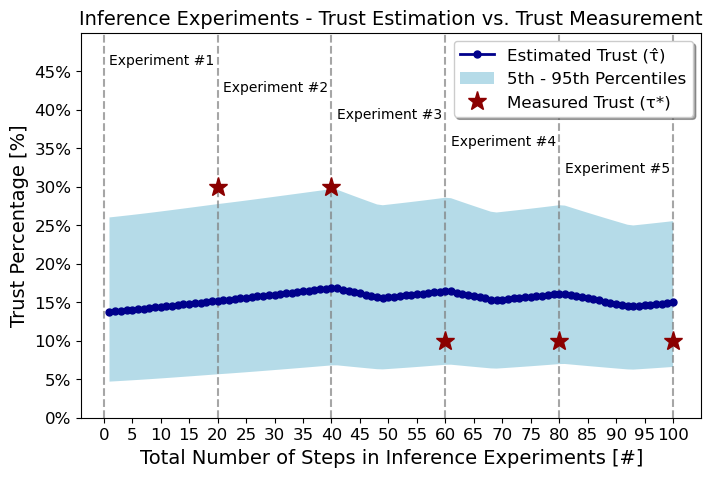

In [11]:
experiment_column = "Experiment"
step_number_column = "TimeStep"
ground_truth_column = "TrustLabel"
estimation_column = "TrustEstimation"
estimationQ5_column = "TrustEstimationQ5"
estimationQ95_column = "TrustEstimationQ95"

number_of_experiments = inference_results_df[experiment_column].max()

total_steps = list(range(1,
                         (number_of_experiments * constants.TRAJECTORY_SIZE) + 1))
trust_estimations = inference_results_df[estimation_column].values
trust_estimations_quantile5 = inference_results_df[estimationQ5_column].values
trust_estimations_quantile95 = inference_results_df[estimationQ95_column].values
trust_labels = inference_results_df[ground_truth_column][
    inference_results_df[step_number_column] == constants.TRAJECTORY_SIZE].values

fig, ax1 = plt.subplots(1, 1,
                        figsize=(8, 5))

ax1.plot(total_steps,
         trust_estimations,
         color="darkblue",
         marker="o",
         markersize=5,
         linestyle="-",
         linewidth=2,
         zorder=3)

ax1.fill_between(x=total_steps,
                 y1=trust_estimations_quantile5,
                 y2=trust_estimations_quantile95,
                 color="lightblue",
                 alpha=0.9,
                 edgecolor="none",
                 zorder=1)

for exp_number in range(1, number_of_experiments + 1):
    ax1.text(((exp_number - 1) * constants.TRAJECTORY_SIZE) + 1,
             0.49 - (exp_number * 0.035),
             f"Experiment #{exp_number}",
             color="black",
             ha="left",
             va="bottom",
             fontsize=10)

    ax1.plot(exp_number * constants.TRAJECTORY_SIZE,
             trust_labels[exp_number - 1],
             marker="*",
             markersize=14,
             linewidth=0,
             color="darkred",
             zorder=4)

for i in range(0, len(total_steps) + 1, constants.TRAJECTORY_SIZE):
    ax1.axvline(x=i,
                color="grey",
                linestyle="--",
                alpha=0.7,
                zorder=2)

ax1.set_ylim(0.0, 0.5)
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0,
                                                          decimals=0))
plt.xticks(np.arange(0, 101, 5),
           fontsize=12)
plt.yticks(np.arange(0, 0.5, 0.05),
           fontsize=12)

ax1.set_xlabel("Total Number of Steps in Inference Experiments [#]",
               fontsize=14)
ax1.set_ylabel("Trust Percentage [%]",
               fontsize=14)
ax1.set_title("Inference Experiments - Trust Estimation vs. Trust Measurement",
              fontsize=14)

ax1.legend(loc="upper right",
           shadow=True,
           labels=["Estimated Trust (τ̂)", "5th - 95th Percentiles", "Measured Trust (τ*)"],
           fontsize=12)

plt.savefig(f"inference_experiments_self_estimated_vs_measured_trust.png", dpi=600, bbox_inches="tight")

plt.show()